In [1]:
import pandas as pd

# Load datasets
train_data = pd.read_csv('C:\\Users\\pimadaba\\Downloads\\walmart-recruiting-store-sales-forecasting\\train.csv\\train.csv')
stores_data = pd.read_csv('C:\\Users\\pimadaba\\Downloads\\walmart-recruiting-store-sales-forecasting\\stores.csv')
features_data = pd.read_csv('C:\\Users\\pimadaba\\Downloads\\walmart-recruiting-store-sales-forecasting\\features.csv\\features.csv')

# Drop rows with missing critical values
train_data.dropna(subset=["Store", "Date"], inplace=True)
features_data.dropna(subset=["Store", "Date"], inplace=True)

# Fill missing markdown values with 0
markdown_columns = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]
features_data[markdown_columns] = features_data[markdown_columns].fillna(0)

# Convert Date to datetime
train_data["Date"] = pd.to_datetime(train_data["Date"])
features_data["Date"] = pd.to_datetime(features_data["Date"])

# Merge datasets
merged_data = pd.merge(train_data, stores_data, on="Store", how="left")
merged_data = pd.merge(merged_data, features_data, on=["Store", "Date"], how="left")

# Add derived columns
merged_data["Month"] = merged_data["Date"].dt.month
merged_data["Day_of_Week"] = merged_data["Date"].dt.day_name()

bins = [-50, 0, 15, 30, 50]
labels = ["Very Cold", "Cold", "Warm", "Hot"]
merged_data["Temperature_Category"] = pd.cut(merged_data["Temperature"], bins=bins, labels=labels)

# Save the final dataset
merged_data.to_csv("merged_data.csv", index=False)
print("Merged dataset saved as 'merged_data.csv'")


Merged dataset saved as 'merged_data.csv'


In [2]:
import os
print(os.getcwd())

C:\Users\pimadaba


In [3]:
print(merged_data["Temperature"].describe())
print(merged_data["Temperature"].unique())

count    421570.000000
mean         60.090059
std          18.447931
min          -2.060000
25%          46.680000
50%          62.090000
75%          74.280000
max         100.140000
Name: Temperature, dtype: float64
[42.31 38.51 39.93 ... 75.87 77.55 74.09]


In [15]:
import pandas as pd

# Load the merged dataset
merged_data_path = "C:\\Users\\pimadaba\\updated_merged_data_v2.csv"  # Replace with your actual path
merged_data = pd.read_csv(merged_data_path)

# Correct the binning logic
# Ensure the minimum temperature (-2.06) is included in the first bin
bins = [-20, 32, 50, 70, 90, 110]  # Adjusted bins to cover all possible values
labels = ["Freezing", "Cold", "Moderate", "Warm", "Very Hot"]

# Recreate the Temperature_Category column
merged_data["Temperature_Category"] = pd.cut(
    merged_data["Temperature"], bins=bins, labels=labels, right=True, include_lowest=True
)

# Verify the updated Temperature_Category
print(merged_data["Temperature_Category"].value_counts())

# Save the updated dataset
merged_data.to_csv("updated_merged_data_fixed.csv", index=False)
print("Updated dataset saved as 'updated_merged_data_fixed.csv'")

Moderate    151439
Warm        133302
Cold         90626
Freezing     35503
Very Hot     10700
Name: Temperature_Category, dtype: int64
Updated dataset saved as 'updated_merged_data_fixed.csv'


In [29]:
import pandas as pd

# Load the dataset
data = pd.read_csv("C:\\Users\\pimadaba\\Downloads\\updated_merged_data_fixed.csv")

# 1. Handle missing values
print("Missing values before:")
print(data.isnull().sum())

data['Temperature_Category'] = data['Temperature_Category'].fillna('Freezing')  # Example fix

# 2. Remove duplicates
print("Duplicate rows before:", data.duplicated().sum())
data = data.drop_duplicates()

# 3. Normalize text formats (e.g., for categorical columns)
if 'Store_Type' in data.columns:
    data['Store_Type'] = data['Store_Type'].str.strip().str.lower()

print("Missing values and duplicates handled.")

# Save the cleaned dataset
data.to_csv("cleaned_dataset.csv", index=False)
print("Cleaned dataset saved.")

Missing values before:
Store                   0
Dept                    0
Date                    0
Weekly_Sales            0
IsHoliday_x             0
Size                    0
Temperature             0
Fuel_Price              0
CPI                     0
Unemployment            0
IsHoliday_y             0
Month                   0
Day_of_Week             0
Temperature_Category    0
dtype: int64
Duplicate rows before: 0
Missing values and duplicates handled.
Cleaned dataset saved.


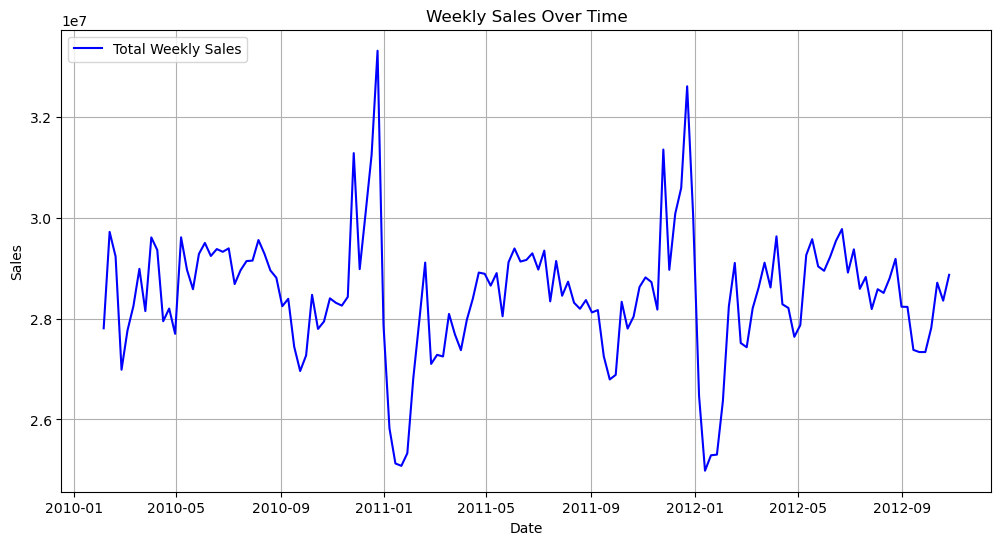

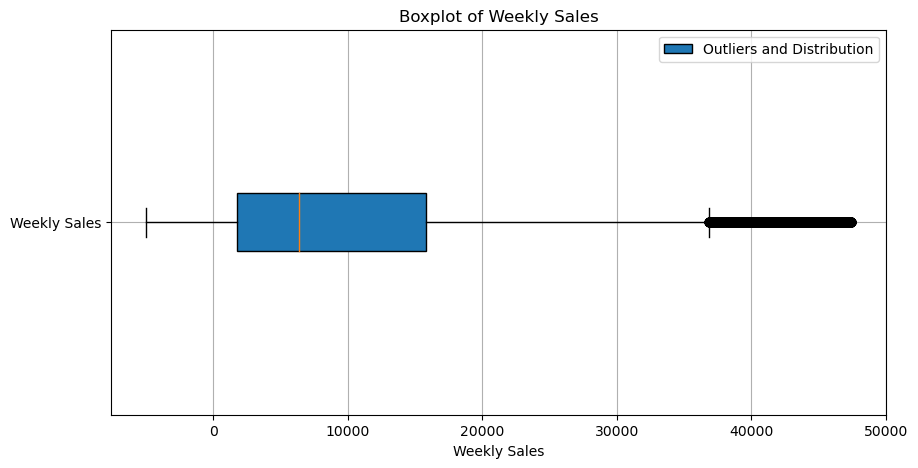

In [41]:
import matplotlib.pyplot as plt

# Sales trends over time
data['Date'] = pd.to_datetime(data['Date'])
sales_trend = data.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(12, 6))
plt.plot(sales_trend, label='Total Weekly Sales', color='blue')
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid()
plt.legend(loc='upper left')  # Adding legend
plt.show()

# Boxplot for Weekly Sales (to visualize outliers)
plt.figure(figsize=(10, 5))
plt.boxplot(data['Weekly_Sales'], vert=False, patch_artist=True, labels=['Weekly Sales'])
plt.title("Boxplot of Weekly Sales")
plt.xlabel("Weekly Sales")
plt.grid()
plt.legend(['Outliers and Distribution'], loc='upper right')  # Adding legend
plt.show()

In [51]:
import pandas as pd
import plotly.express as px

# Example data (replace with your actual grouped data)
top_stores = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(5)
top_depts = data.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(5)

# Convert to DataFrame
top_stores_df = top_stores.reset_index()
top_depts_df = top_depts.reset_index()

# Ensure sorted in descending order
top_stores_df = top_stores_df.sort_values(by='Weekly_Sales', ascending=False)
top_depts_df = top_depts_df.sort_values(by='Weekly_Sales', ascending=False)

# ----------- Stores Chart (Vertical Bars) -----------
fig_stores = px.bar(
    top_stores_df,
    x='Store',
    y='Weekly_Sales',
    title="Top Performing Stores (January)",  # Example: Month in title
    labels={'Weekly_Sales': 'Total Sales ($)', 'Store': 'Store'},
    text='Weekly_Sales',  # Add text labels
    color='Weekly_Sales',  # Gradient based on sales
    color_continuous_scale='Blues',  # Pleasing blue color palette
)

# Update traces for stores
fig_stores.update_traces(
    texttemplate='%{text:,}',  # Format text with commas
    textfont_size=14,  # Consistent text size
    textposition='outside',  # Place text outside bars
    hovertemplate='Store: %{x}<br>Total Sales: %{y:,}<extra></extra>'  # Hover format
)

# Update layout for stores chart
fig_stores.update_layout(
    title={'x': 0.5},  # Center title
    xaxis_title="Store",
    yaxis_title="Total Sales ($)",
    yaxis=dict(tickformat=',', showgrid=False),  # Remove gridlines, format axis
    xaxis=dict(showgrid=False),
    plot_bgcolor="white",  # White background
    height=600,  # Increased height
    width=1000,  # Increased width
)
fig_stores.show()

# ----------- Departments Chart (Horizontal Bars) -----------
fig_depts = px.bar(
    top_depts_df,
    x='Weekly_Sales',
    y='Dept',
    title="Top Performing Departments (January)",  # Example: Month in title
    labels={'Weekly_Sales': 'Total Sales ($)', 'Dept': 'Department'},
    text='Weekly_Sales',  # Add text labels
    orientation='h',  # Horizontal bar chart for better readability
    color='Weekly_Sales',  # Gradient based on sales
    color_continuous_scale='Oranges',  # Pleasing orange color palette
)

# Update traces for departments
fig_depts.update_traces(
    texttemplate='%{text:,}',  # Format text with commas
    textfont_size=14,  # Consistent text size
    textposition='inside',  # Place text inside bars
    hovertemplate='Department: %{y}<br>Total Sales: %{x:,}<extra></extra>'  # Hover format
)

# Update layout for departments chart
fig_depts.update_layout(
    title={'x': 0.5},  # Center title
    xaxis_title="Total Sales ($)",
    yaxis_title="Department",
    xaxis=dict(tickformat=',', showgrid=False),  # Remove gridlines, format axis
    yaxis=dict(showgrid=False),
    plot_bgcolor="white",  # White background
    height=600,  # Increased height
    width=900,  # Increased width
)
fig_depts.show()

In [52]:
# Create new features
# Holiday Boost
data['Holiday_Boost'] = data['IsHoliday_x'] * data['Weekly_Sales']

# Customer Metrics: Average Spend
data['Average_Spend'] = data['Weekly_Sales'] / data['Size']

# Store Metrics: Sales Per Square Foot
data['Sales_Per_Sq_Ft'] = data['Weekly_Sales'] / data['Size']

# Save the dataset with new features
data.to_csv("feature_engineered_data.csv", index=False)
print("Feature-engineered dataset saved.")

Feature-engineered dataset saved.


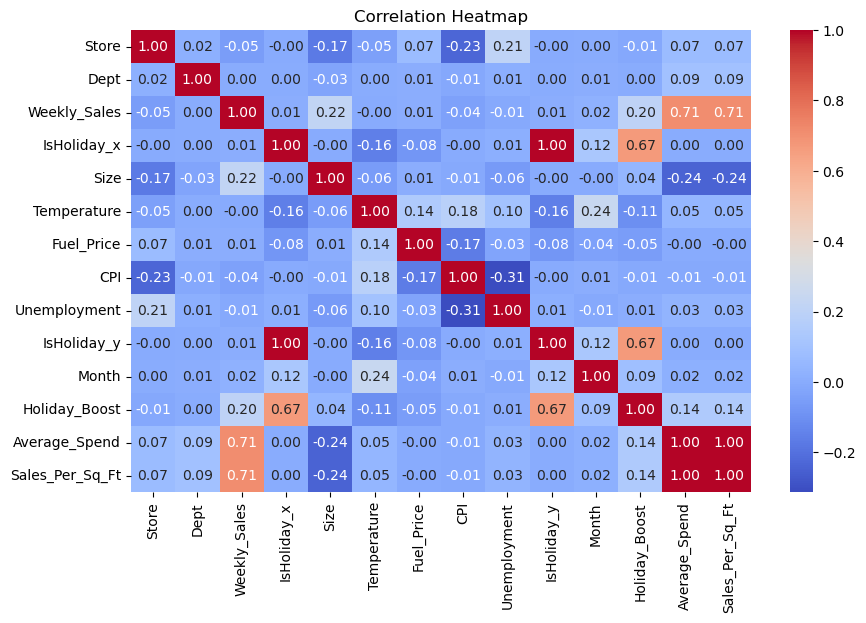

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix for numeric columns
correlation_matrix = data.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [56]:
from sklearn.cluster import KMeans
import pandas as pd

# Example: Cluster stores based on Weekly Sales and Size
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # Explicitly set n_init to 10
data['Cluster'] = kmeans.fit_predict(data[['Weekly_Sales', 'Size']].dropna())

# Cluster counts
print("Cluster Counts:")
print(data['Cluster'].value_counts())

# Save the dataset with clusters
data.to_csv("clustered_data.csv", index=False)
print("Dataset with clusters saved.")

Cluster Counts:
0    165846
1    130380
2     89823
Name: Cluster, dtype: int64
Dataset with clusters saved.


In [59]:
data.to_csv("tableau_ready_data.csv", index=False)
print("Dataset exported for Tableau.")

Dataset exported for Tableau.
